# Glaucoma Segmentation


## Imports

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from models import *
from training import *
from utils import *

## Setup

In [2]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
LOGS_DIR = '../logs/'
CHECKPOINT_DIR = '../checkpoints/'
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
in_channels = 3
out_channels = 1
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 3
LAYERS = [32, 64, 128, 256, 512]
EARLY_STOPPING_PATIENCE = 10
SAVE_INTERVAL = 10
NUM_WORKERS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PIN_MEMORY = True if DEVICE == 'cuda' else False
LOAD_MODEL = ''
USE_WANDB = False
DEEP_SUPERVISION = False

os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {DEVICE}')

PyTorch version: 2.0.1+cu118
Using device: cuda


## Dataset

Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Unique values and their counts in mask: {0: 5922, 1: 5486, 2: 4976}


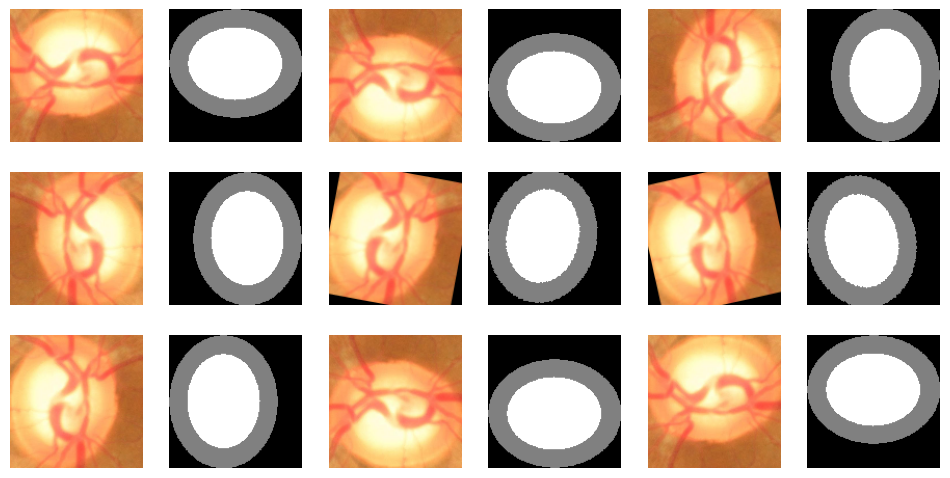

In [3]:
example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, os.listdir(IMAGE_DIR)[:1], A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees
    A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2(),
]))
example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)

example_image, example_mask = next(iter(example_loader))
print(f'Image shape: {example_image.shape}')
print(f'Mask shape: {example_mask.shape}')

unique, counts = np.unique(example_mask, return_counts=True)
print(f'Unique values and their counts in mask: {dict(zip(unique, counts))}')

# Plot example augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()
for i in range(0, 3 * 6, 2):
    batch = next(iter(example_loader))
    images, masks = batch
    image, mask = images[0], masks[0]
    image = image.permute(1, 2, 0).numpy()
    mask = mask.numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')
plt.show()

In [4]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ToTensorV2(),
])

train_loader, val_loader, test_loader = load_origa(
    IMAGE_DIR, MASK_DIR, 0.7, 0.15, 0.15,
    train_transform, val_transform, val_transform, BATCH_SIZE, PIN_MEMORY, NUM_WORKERS
)

Loading ORIGA dataset:
    Train size: 454 (69.85%)
    Validation size: 98 (15.08%)
    Test size: 98 (15.08%)
    
    Image shape: (3, 128, 128)
    Mask shape: (128, 128)
    Batch size: 4

    Train loader length: 114
    Validation loader length: 25
    Test loader length: 25


## Model

In [5]:
# initialize model, loss, optimizer, scheduler, scaler, ...
model = Unet(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)
# model = UnetPlusPlus(in_channels=in_channels, out_channels=out_channels, features=LAYERS, deep_supervision=DEEP_SUPERVISION).to(DEVICE)
# model = Unet3Plus(in_channels=in_channels, out_channels=out_channels, features=LAYERS, deep_supervision=DEEP_SUPERVISION).to(DEVICE)

# model = AttentionUnet(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)
# model = InceptionUnet(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)

# model = ResUnet(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)
# model = RUnet(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)
# model = R2Unet(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)

# model = SqueezeUnet(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)

# model = R2AttentionUnet(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)
# model = R2UnetPlusPlus(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)

# model = ResAttentionUnetPlusPlus(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)
# model = RefUnet3PlusCBAM(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)
# model = DualRAUnetPlusPlus(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)
model = DualRefUnet3PlusCBAM(in_channels=in_channels, out_channels=out_channels, features=LAYERS).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# criterion = nn.CrossEntropyLoss()  # softmax layer is already included inside nn.CrossEntropyLoss()
criterion = DiceLoss(num_classes=out_channels)
# criterion = GeneralizedDice(num_classes=out_channels)
# criterion = IoULoss(num_classes=out_channels)
# criterion = FocalLoss(num_classes=out_channels)
# criterion = TverskyLoss(num_classes=out_channels)
# criterion = FocalTverskyLoss(num_classes=out_channels)
# criterion = HausdorffLoss(num_classes=out_channels)
# criterion = BoundaryLoss(num_classes=out_channels)
# criterion = CrossEntropy(num_classes=out_channels)
# criterion = SensitivitySpecificityLoss(num_classes=out_channels)
# criterion = EdgeLoss(num_classes=out_channels)
# criterion = ComboLoss(num_classes=out_channels)

# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

scaler = None
# scaler = torch.cuda.amp.GradScaler()

if LOAD_MODEL:
    load_checkpoint(LOAD_MODEL, model, optimizer)

## Training

Epoch 1:


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, accuracy_OC=0.903, accuracy_OD=0.943, dice_OC=0.833, dice_OD=0.959, iou_OC=0.716, iou_OD=0.922, loss=0.58, loss_OC=0.444, loss_OD=0.136, precision_OC=0.757, precision_OD=0.968, sensitivity_OC=0.937, sensitivity_OD=0.952, specificity_OC=0.895, specificity_OD=0.922] 


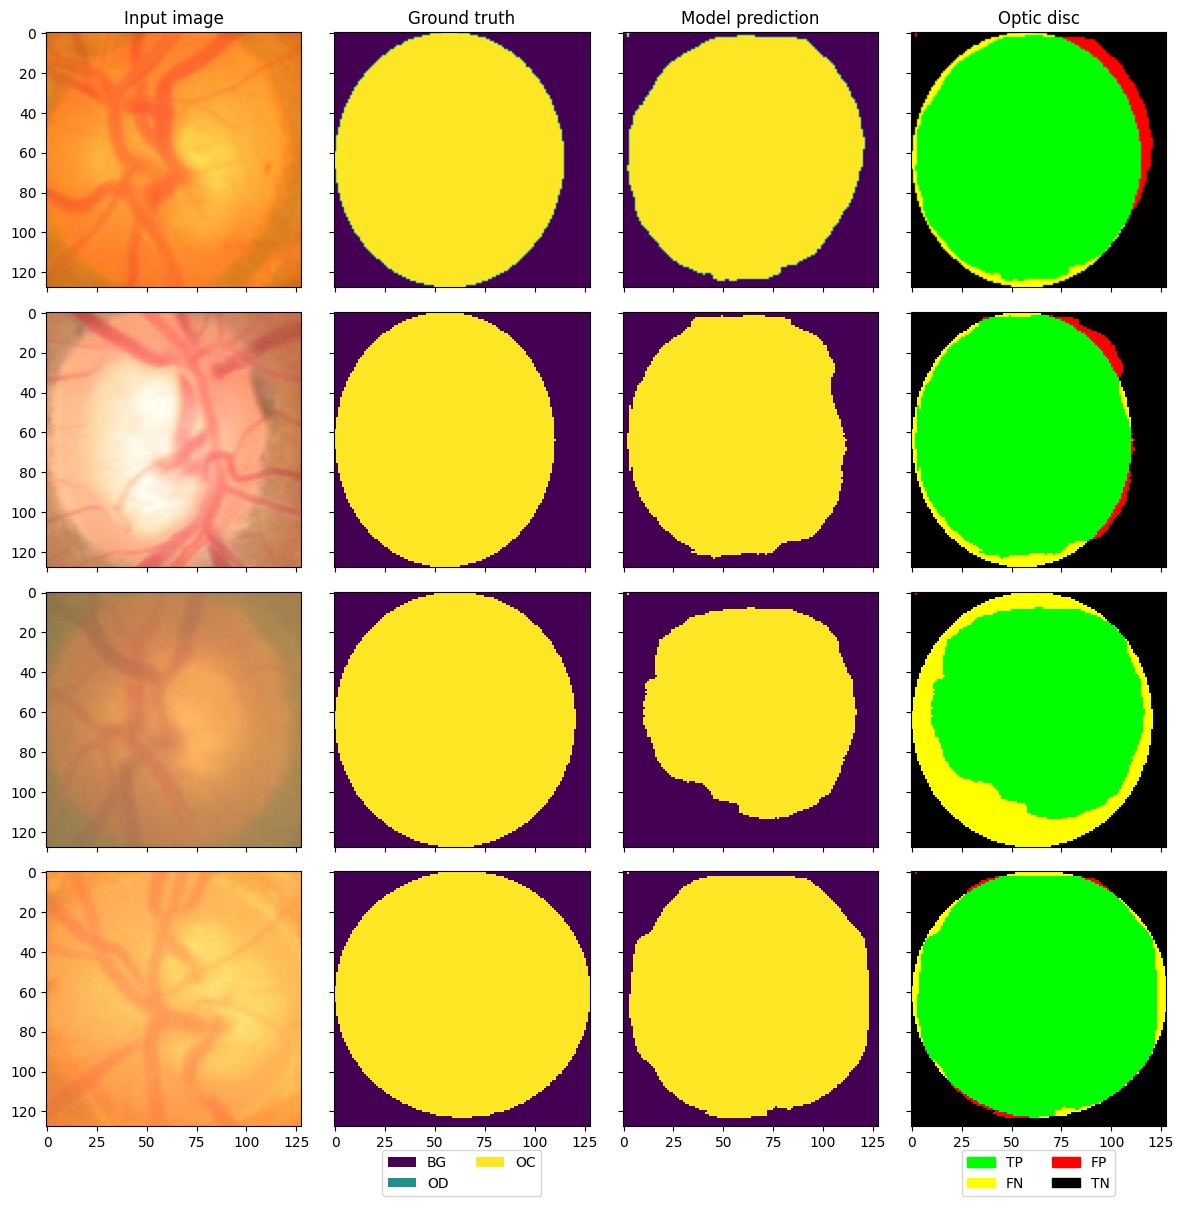

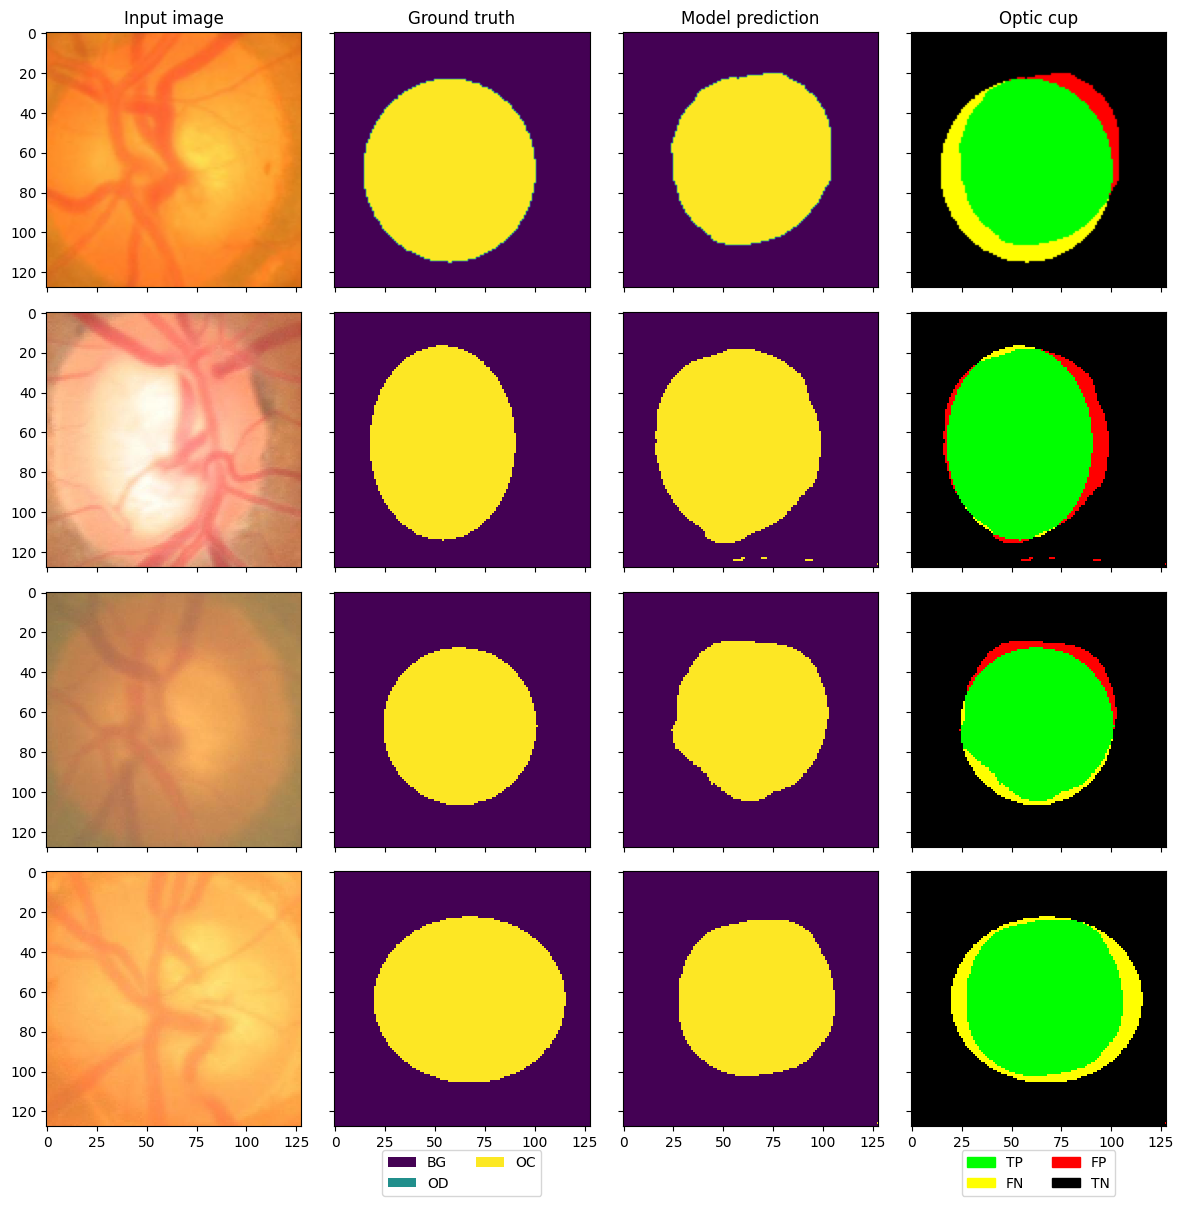

Epoch 2:


Training:   0%|          | 0/114 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [6]:
# hist = train_multiclass(
#     model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
#     save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
#     log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, checkpoint_dir=CHECKPOINT_DIR,
#     save_best_model=False,
# )

# hist = train_binary(
#     model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
#     save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
#     log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, checkpoint_dir=CHECKPOINT_DIR,
#     save_best_model=False,
# )

hist = train_dual(
    model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
    save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
    log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, checkpoint_dir=CHECKPOINT_DIR,
    save_best_model=False,
    show_plots=True,
)

In [ ]:
# Plot metrics
used_metrics = sorted([m[6:] for m in hist.keys() if m.startswith('train_')])
fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.ravel()

for i, metric in enumerate(used_metrics):
    ax[i].plot(hist[f'train_{metric}'], label=f'train')
    ax[i].plot(hist[f'val_{metric}'], label=f'val')
    ax[i].set_title(metric[0].upper() + metric[1:].replace('_', ' '))
    if metric != 'loss':
        ax[i].set_ylim(top=1)
    ax[i].legend()

for ax in ax[len(used_metrics):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Testing

In [ ]:
results = evaluate(model, criterion, DEVICE, test_loader)

In [ ]:
plot_results_from_loader(test_loader, model, DEVICE, types='all', n_samples=4, save_path=f'{LOGS_DIR}/evaluation.png')

## Work in progress

In [ ]:
# torch.save(model.state_dict(), CHECKPOINT_DIR + 'model.pth')

checkpoint = torch.load(CHECKPOINT_DIR + 'model.pth')
model = Unet(in_channels=3, out_channels=3).to(DEVICE)
model.load_state_dict(checkpoint)

In [ ]:
exam = get_best_OC_examples(model, test_loader, n=3)

images = [exam[i][0] for i in range(3)]
masks = [exam[i][1] for i in range(3)]
preds = [exam[i][2] for i in range(3)]

plot_results(images, masks, preds)

In [ ]:
num_classes = 3

model = Unet(in_channels=3, out_channels=num_classes).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss = DiceLoss(num_classes=num_classes)
# loss = GeneralizedDice(num_classes=num_classes)
# loss = IoULoss(num_classes=num_classes)
# loss = FocalLoss(num_classes=num_classes)
# loss = TverskyLoss(num_classes=num_classes)
# loss = FocalTverskyLoss(num_classes=num_classes)
# loss = HausdorffLoss(num_classes=num_classes)
# loss = BoundaryLoss(num_classes=num_classes)
# loss = CrossEntropy(num_classes=num_classes)
# loss = SensitivitySpecificityLoss(num_classes=num_classes)
# loss = EdgeLoss(num_classes=num_classes)
# loss = ComboLoss(num_classes=num_classes)

for epoch in range(5):
    acc_loss = 0
    for images, masks in val_loader:
        images = images.float().to(DEVICE)
        masks = masks.long().to(DEVICE)

        if num_classes == 1:
            masks = torch.where(masks > 0, torch.tensor(1).to(DEVICE), torch.tensor(0).to(DEVICE))

        outputs = model(images)
        loss_value = loss(outputs, masks)
        acc_loss += loss_value.item()

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

    # plot example
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    if num_classes > 1:
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()
    else:
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float().cpu().numpy().transpose(0, 2, 3, 1)

    _, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(images[0].transpose(1, 2, 0) / 255.0)
    ax[1].imshow(masks[0])
    ax[2].imshow(preds[0])
    plt.show()

    print(f'Epoch {epoch + 1} loss:', acc_loss / len(val_loader))


## TODO: find out wtf is going on with the model's output

In [ ]:
images, masks = next(iter(val_loader))

# change order of images
# new_order = [0, 1, 0, 3]
# images = images[new_order]
# masks = masks[new_order]

images = images.float().to(DEVICE)
masks = masks.long().to(DEVICE)

outputs = model(images)
probs = F.softmax(outputs, dim=1)
preds = torch.argmax(probs, dim=1)

# plot probs
_, ax = plt.subplots(4, 6, figsize=(18, 12))
for i in range(4):
    ax[i, 0].imshow(images[i].cpu().numpy().transpose(1, 2, 0) / 255.0)
    ax[i, 1].imshow(masks[i].cpu().numpy())
    ax[i, 2].imshow(probs[i, 0].cpu().detach().numpy())
    ax[i, 3].imshow(probs[i, 1].cpu().detach().numpy())
    ax[i, 4].imshow(probs[i, 2].cpu().detach().numpy())
    ax[i, 5].imshow(preds[i].cpu().detach().numpy())
plt.show()

In [ ]:
image = images[1]
mask = masks[1]
rotated = torch.cat(
    [torch.rot90(image, k=k, dims=(1, 2)).unsqueeze(0) for k in range(4)] + \
    [torch.rot90(torch.flip(image, dims=(1,)), k=k, dims=(1, 2)).unsqueeze(0) for k in range(4)], dim=0)
rotated = rotated.to(DEVICE)

rotated_mask = torch.cat(
    [torch.rot90(mask, k=k, dims=(0, 1)).unsqueeze(0) for k in range(4)] + \
    [torch.rot90(torch.flip(mask, dims=(0,)), k=k, dims=(0, 1)).unsqueeze(0) for k in range(4)], dim=0)

outputs = model(rotated)
probs = F.softmax(outputs, dim=1)
preds = torch.argmax(probs, dim=1)

# plot probs
fig, ax = plt.subplots(4, 6, figsize=(18, 12))
for i in range(4):
    ax[i, 0].imshow(rotated[i].cpu().numpy().transpose(1, 2, 0) / 255.0)
    ax[i, 1].imshow(rotated_mask[i].cpu().numpy())
    ax[i, 2].imshow(probs[i, 0].cpu().detach().numpy())
    ax[i, 3].imshow(probs[i, 1].cpu().detach().numpy())
    ax[i, 4].imshow(probs[i, 2].cpu().detach().numpy())
    ax[i, 5].imshow(preds[i].cpu().detach().numpy())
plt.show()


In [ ]:
output = model(image.unsqueeze(0).to(DEVICE))
probs = F.softmax(output, dim=1)
pred = torch.argmax(probs, dim=1)

# plot probs
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
ax[0].imshow(image.cpu().numpy().transpose(1, 2, 0) / 255.0)
ax[1].imshow(mask.cpu().numpy())
ax[2].imshow(probs[0, 0].cpu().detach().numpy())
ax[3].imshow(probs[0, 1].cpu().detach().numpy())
ax[4].imshow(probs[0, 2].cpu().detach().numpy())
ax[5].imshow(pred[0].cpu().detach().numpy())
plt.show()

## Contour detection method

In [ ]:
from skimage import segmentation
from scipy.ndimage import distance_transform_edt

images, masks = next(iter(val_loader))
images = images.float().to(DEVICE)
masks = masks.long().to(DEVICE)

image = images[0].cpu().numpy().transpose(1, 2, 0) / 255.0
mask = masks[0].cpu().numpy()
prediction = np.zeros_like(mask)
prediction[16:112, 16:112] = 1
prediction[32:96, 32:96] = 2

boundaries = segmentation.find_boundaries(mask, mode='inner').astype(np.uint8)
marked = image.copy()
marked[boundaries == 1] = [0, 0, 0]
dist_map = distance_transform_edt(1 - boundaries)
dist_map = dist_map / dist_map.max()

_, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0, 0].imshow(mask)
ax[0, 1].imshow(boundaries)
ax[0, 2].imshow(dist_map)
ax[0, 3].imshow(dist_map.max() - dist_map)
ax[1, 0].imshow(prediction)
ax[1, 1].imshow(marked)
plt.show()

In [ ]:
model = Unet(in_channels=3, out_channels=1).to(DEVICE)
loss = DiceLoss(num_classes=1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(5):
    acc_loss = 0
    for images, masks in val_loader:

        edge_masks = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2]))
        for b in range(masks.shape[0]):
            mask = masks[b].cpu().numpy()
            boundaries = segmentation.find_boundaries(mask, mode='thick').astype(np.uint8)
            edge_masks[b] = boundaries
        masks = torch.from_numpy(edge_masks)

        images = images.float().to(DEVICE)
        masks = masks.long().to(DEVICE)

        outputs = model(images)
        loss_value = loss(outputs, masks)
        acc_loss += loss_value.item()

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

    # plot example
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    # probs = F.softmax(outputs, dim=1)
    # preds = torch.argmax(probs, dim=1).cpu().numpy()
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float().cpu().numpy().transpose(0, 2, 3, 1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(images[0].transpose(1, 2, 0) / 255.0)
    ax[1].imshow(masks[0])
    ax[2].imshow(preds[0])
    plt.show()

    print(f'Epoch {epoch + 1} loss:', acc_loss / len(val_loader))
